In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import CubicSpline

In [67]:
%run getStrikefromDelta.ipynb
%run ForwardSpot.ipynb
%run getMarket.ipynb
%run getBlackCall.ipynb

In [68]:
def makeSmile ( fwdCurve , T, cps , deltas , vols ):
    '''
    Inputs :
    fwdCurve : forward curve data
    T: time to expiry of the option
    cps: vetor if 1 for call , -1 for put
    deltas : vector of delta in absolute value (e.g. 0.25)
    vols : vector of volatilities
    Output :
    curve : a struct containing data needed in getSmileK
    '''
    fwd = getFwdSpot(fwdCurve, T)
    Ks = getStrikefromDelta(fwd, T, cps, vols, deltas)
    #check arbitrage
    Cs = getBlackCall(fwd, T, Ks, vols)
    K, C=np.insert(Ks,0,0), np.insert(Cs,0,fwd)
    slope = np.diff(C)/np.diff(K)
    slope_diff = np.diff(slope)
    assert slope_diff.any()>0, "The price of a Call option is convex in strike" 
    #interpolation in strike via CubicSpline
    cs = CubicSpline(Ks, vols)
    #extrapolation
    KL = Ks[0]**2/Ks[1]
    KR = Ks[-1]**2/Ks[-2]
    bR = np.arctanh(np.sqrt(0.5))/(KR-Ks[-1])
    bL = np.arctanh(np.sqrt(0.5))/(Ks[0]-KL)
    aR = cs(Ks[-1],1)/bR
    aL = -cs(Ks[0],1)/bL
    volCurve = {"cs": cs, "KL": KL, "KR": KR, "bR": bR, "bL": bL, "aR": aR, "aL": aL, "K1": Ks[0], "KN": Ks[-1] }
    return volCurve

In [71]:
curve
fwd = getFwdSpot(curve, T)
T = np.array([181])
fwd = getFwdSpot(curve, T)
delta = deltas
cp = cps
vols_6 = vols.loc[6]

In [72]:
volCurve = makeSmile(curve, T, cp, delta, vols_6)
volCurve['K1']

1.203187112033201

In [73]:
def getSmileVol(volCurve, Ks):
    '''
    Inputs :
    volCurve : pre - computed smile data
    Ks: vetor of strikes
    Output :
    vols : implied volatility at strikes Ks
    '''
    vols = np.zeros_like(Ks)
    cs = volCurve['cs']
    K1, KN = volCurve['K1'], volCurve['KN']
    KL, KR = volCurve['KL'], volCurve['KR']
    aL, aR = volCurve['aL'], volCurve['aR']
    bL, bR = volCurve['bL'], volCurve['bR']
    for i in range(len(Ks)):
        K = Ks[i]
        if K<K1:
            vols[i] = cs(K1) + aL*np.tanh(bL*(K1-K))
        elif K>KN:
            vols[i] = cs(KN) + aR*np.tanh(bR*(K-KN))
        else:
            vols[i] = cs(K)
    return vols

In [74]:
Ks = np.arange(1,2,0.01)
vols = getSmileVol(volCurve, Ks)

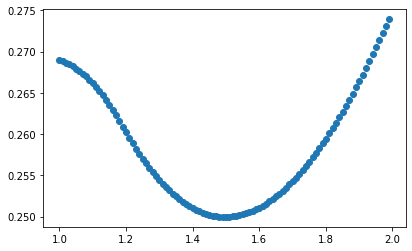

In [75]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(Ks, vols, 'o', label='data')